# Overview


This notebook describes the different stages to build up different deep learning models trained over the dataset called **ISOT** by using **TFIDF** tokenisation, for the automatic fake news detection

List of Deep Learning algorithms included 
- 1D CNN
- LSTM
- BiLSTM



## 1. Loading Python libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tensorflow_hub as hub
import tensorflow_text
import tldextract  
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, roc_auc_score,f1_score,precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re

from collections import Counter
import nltk 
import spacy
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from pprint import pprint


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Activation,Embedding,Flatten,LSTM,Bidirectional,GlobalMaxPooling1D
from tensorflow.keras.layers import Reshape,Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from keras.backend import clear_session


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

2022-07-08 21:01:18.928613: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-08 21:01:20.346237: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-07-08 21:01:20.346295: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading 

#### Loading the ISOT Full Dataset  -- After combined fake and real news  in the previous notebook   "ISOT_ML_Classifiers_TfiDF_Tokeniser"

In [2]:
isot_full_df = pd.read_csv("Updated//ISOT_Combined_FullData.csv")

***
## 2. Text Preprocessing

### Combining different stopwords lists loaded from different libraries to create a consolidated stopwords list

In [3]:
#loading the english language small model of spacy
import spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

Fetching different stopword lists from the different libraries **(gensim,nltk,spacy,wordcloud)** and combined to create a consolidated Stopword list

In [4]:
gensim_stopwords_list=list(gensim_stopwords) # gensim
nltk_stopwords_list=stopwords.words('english') # nltk
spacy_stopwords=list(sw_spacy) # spacy
wordcloud_stopwords_list=list(STOPWORDS)

In [5]:
total_stop_words_list= set(gensim_stopwords_list + nltk_stopwords_list + spacy_stopwords + wordcloud_stopwords_list)

#### Function to tag POS tagging for each news content

In [ ]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag,wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

#####  Preprocessing 


We have experimented   the following pre-processing methods in our classification work:

- Removal any HTML content
- Remove URLs and numbers
- Removal of all kinds of date formats
- Removal of Punctuation 
- Conversion of lower case
- Replacing 2 or more consecutive whitespaces with a single one
- Removal of Stopwords
- Lemmatization
- Stemming
- POS tagging 


#### Helper Function to preprocess the text  with all the operations as mentioned above

In [7]:
def clean_format(text):
    # Remove HTML tags
    bsoup = BeautifulSoup(text, "html.parser")
    clean_text = bsoup.get_text()
    
    
    # Remove any URL
    url = re.compile(r'https?://\S+|www\.\S+')
    url.sub(r'', clean_text)
    
    # Remove any numbers
    clean_text=re.sub(r'\d+','',clean_text)
    
    # Remove all kinds of date formats
    clean_text=re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', clean_text)
    clean_text=re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', clean_text)
    clean_text=re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', clean_text)
    
    
    # Removal of punctuation and lower case conversion
    clean_text = re.sub('\[[^]]*\]', ' ', clean_text)
    clean_text = re.sub('[^a-zA-Z]',' ',clean_text)  # replaces non-alphabets with spaces
    clean_text = clean_text.lower()
    
    # Removal of 2 consecutive double space
    clean_text=re.sub(r' {2,}',' ',clean_text)
    
    clean_text = clean_text.split()
    
    textclean=[]
    clean_text = [textclean.append(word) for word in clean_text if word not in total_stop_words_list and len(word) > 2]
    clean_text = ' '.join(textclean)
    
#     # Lemmatization
    clean_text = clean_text.split()
    lemmatizer = WordNetLemmatizer()
    newcleantext= [lemmatizer.lemmatize(w) for w in clean_text]
    newcleantext = ' '.join(newcleantext)
    
    return newcleantext

#### Drop the non required columns 

In [8]:
isot_full_df = isot_full_df.drop(columns = ['title','text', 'subject','date','title_length','body_length','date'])

In [9]:
isot_full_df=isot_full_df.reset_index(drop=True)

Apply the above function on the column **fulltext**  for the preprocessing step

In [11]:
isot_full_df['cleantext']=isot_full_df['fulltext'].apply(clean_format)

#### Remove the null rows

In [14]:
df = isot_full_df[isot_full_df['cleantext'].notna()]

#### Shuffling the rows

In [15]:

df = df.sample(frac=1).reset_index(drop=True)

***

## 3. Model Training and Evaluation

### Splitting dataset into Features and Class labels

In [16]:
X=df['cleantext'].apply(str)
y=df['class']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=0)

## Feature Extraction

### Initialising  TFIDF Tokenisation uni-gram mode with 3000 maximum features

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
max_features = 3000

tokenizer = TfidfVectorizer(max_features=max_features, ngram_range=(1, 1),
                       tokenizer=nltk.word_tokenize,
                       strip_accents='unicode',
                       lowercase=True, analyzer='word', token_pattern=r'\w+',
                       use_idf=True, smooth_idf=True, sublinear_tf=False)

##### Tokenisation fit & transform on train texts and transform only on test sets

In [24]:
x_train_tf = tokenizer.fit_transform(X_train).toarray()
x_test_tf = tokenizer.transform(X_test).toarray()

#### Printing the shape of different text corpus

In [25]:
print('x_train_tf shape: ', x_train_tf.shape)
print('x_test_tf: ', x_test_tf.shape)

x_train_tf shape:  (30616, 3000)
x_test_tf:  (7654, 3000)


Reshape X_train and X_test data to a format like **[samples, time steps, features]** shape. We are converting this for the models LSTM and BILSTM**

In [26]:
# Reshape data to [samples, time steps, features] shape

print(
    '\nReshaping data to the shape [samples, time steps, features] for LSTM and BILSTM ...')
x_train_tf_dl = np.reshape(
    x_train_tf, (x_train_tf.shape[0], 1, x_train_tf.shape[1]))
x_test_tf_dl = np.reshape(
    x_test_tf, (x_test_tf.shape[0], 1, x_test_tf.shape[1]))
print('\nReshaping done ...')


Reshaping data to the shape [samples, time steps, features] for LSTM and BILSTM ...

Reshaping done ...


Reshape X_train and X_test data to a format like **[samples, features,1]** shape.  We are converting this for the models CNN****

In [27]:
print(
    '\nReshaping data to the shape [samples, features,1] for CNN ...')
x_train_tf_cn = np.reshape(
    x_train_tf, (x_train_tf.shape[0], x_train_tf.shape[1],1))
x_test_tf_cn = np.reshape(
    x_test_tf, (x_test_tf.shape[0], x_test_tf.shape[1],1))


Reshaping data to the shape [samples, features,1] for CNN ...


####  User defined helper functions to plot training and testing accuracy of the trained model

This function is using to save the loss and accuracy metrics of the training and test sets from the given input parameter which is a keras history callback object obtained during the model traning

In [29]:
import matplotlib.pyplot as plt

def plot_loss_and_acc_from_hist2(hist_df):
    print('Training Accuracy :',hist_df.iloc[-1]['accuracy'])
    print('Validation Accuracy :',hist_df.iloc[-1]['val_accuracy'])
    print('Precision :',hist_df.iloc[-1]["precision"])
    print('Recall :',hist_df.iloc[-1]["recall"])
    print('F1 Score :',hist_df.iloc[-1]["f1score"])
    train_loss = hist_df["loss"]
    train_acc = hist_df["accuracy"]
    val_loss = hist_df["val_loss"]
    val_acc = hist_df["val_accuracy"]
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss");
    ax.plot(range(len(val_loss)), val_loss, label="Validation Loss");
    plt.xlabel("Epochs"); plt.ylabel("Loss");
    plt.title("Train Loss vs Validation Loss");
    plt.legend(loc="best");

    ax = fig.add_subplot(122)
    ax.plot(range(len(train_acc)), train_acc, label="Train Accuracy");
    ax.plot(range(len(val_acc)), val_acc, label="Validation Accuracy");
    plt.xlabel("Epochs"); plt.ylabel("Accuracy");
    plt.title("Train Accuracy vs Validation Accuracy");
    plt.legend(loc="best");    

    


#### User defined helper functions to create the confusion matrix and normalised confusion matrix 

The below scripts is using to create the confusion matrix and normalised confusion matrix based on the predictions and actual truth lables

In [30]:
# Helper function to plot confusion matrix and normalised confusion matrix plot
def confusn_mtrx_plot(cm,path):
    from sklearn.metrics import confusion_matrix
    # Y_pred_evc = evc_mdl.predict(test_X)
    #cm = confusion_matrix(ytrue, y_pred)

    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="GnBu", fmt="g");  
    #sns.heatmap(cm/np.sum(cm), annot=True, ax=ax[1], cmap="GnBu", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    #fig.show()
    fig.savefig(path)
    
def norm_confusn_mtrx_plot(cm,path):
    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm/np.sum(cm), annot=True, ax=ax, cmap="GnBu",fmt='.2%');  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'18'}  # Adjust to fit
    ax.set_title('Normalised Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    fig.savefig(path)

***
## Model Training

###  1D CNN

#### Checkpoint and EarlyStopping configuration setting for the model training

In [50]:
# Model Checkpoint and EarlyStopping
filepath = "outputs//isot_dl_tfidf//model_ISOT_CNN_TFIDF_V2.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

#### Build the model 

In [57]:
warnings.filterwarnings('ignore')
model=Sequential()
model.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu',input_shape=(max_features,1)))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2998, 128)         512       
                                                                 
 conv1d_1 (Conv1D)           (None, 2998, 32)          12320     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1499, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 47968)             0         
                                                                 
 dense (Dense)               (None, 128)               6140032   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [58]:
clear_session()

#### Model Training 

In [59]:
warnings.filterwarnings('ignore')
history=model.fit(x_train_tf_cn, y_train, epochs=3, batch_size=32,validation_data=(x_test_tf_cn,y_test), 
                  callbacks=callbacks_list)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
957/957 [==============================] - ETA: 0s - loss: 0.1129 - accuracy: 0.9558WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b2676f0aea0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

#### Evaluate the predictions made based on test data and calculate and plot the accuracy score metrics  and save callback history details to csv

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
240/240 [==============================] - 3s 12ms/step
Training Accuracy : 0.9928142428398132
Validation Accuracy : 0.9792265295982361
Precision : 0.9888464925154095
Recall : 0.9653295128939828
F1 Score : 0.976946498477599


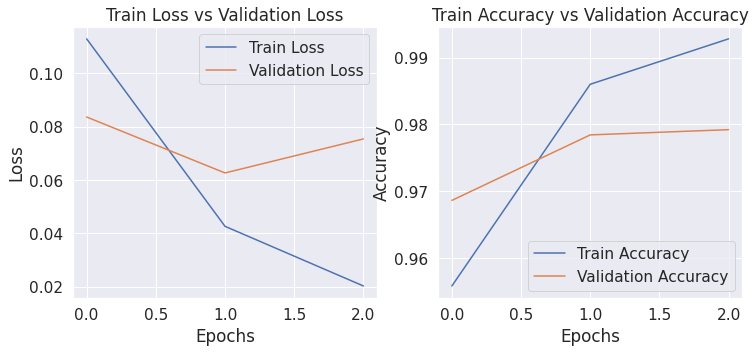

In [60]:
y_pred=model.predict(x_test_tf_cn)
ytrue = y_test.astype(int).tolist()
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)
history.history['precision']=precision
history.history['recall']=recall
history.history['f1score']=f1score
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv("outputs//isot_dl_tfidf//model_ISOT_CNN_TFIDF_V2_history.csv")
plot_loss_and_acc_from_hist2(hist_df)

#### Scoring Metrics

In [61]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.9792265482100863
precision = 0.9888464925154095
recall = 0.9653295128939828
f1score = 0.976946498477599
[[4126   38]
 [ 121 3369]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4164
           1       0.99      0.97      0.98      3490

    accuracy                           0.98      7654
   macro avg       0.98      0.98      0.98      7654
weighted avg       0.98      0.98      0.98      7654



**Save the classification report to csv**

In [62]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_dl_tfidf//model_ISOT_CNN_TFIDF_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
,,,,
0,0.971509,0.990874,0.981096,4164.000000
1,0.988846,0.965330,0.976946,3490.000000
accuracy,0.979227,0.979227,0.979227,0.979227
macro avg,0.980178,0.978102,0.979021,7654.000000
weighted avg,0.979415,0.979227,0.979204,7654.000000


**Plot confusion matrix with normalised plot**

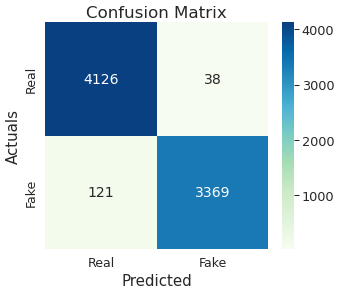

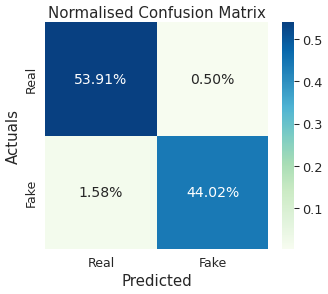

In [63]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//isot_dl_tfidf//isot_cnn_tfidf_cmtrx.png"
path2="outputs//isot_dl_tfidf//isot_cnn_tfidf_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

***

### Using LSTM

#### Checkpoint and EarlyStopping configuration setting for the model training

In [64]:
# Model Checkpoint and EarlyStopping
filepath_lstm = "outputs//isot_dl_tfidf//model_ISOT_LSTM_TFIDF_V2.h5" # Location to get the model
checkpoint_lstm = ModelCheckpoint(filepath_lstm, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_lstm = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_lstm = [checkpoint_lstm,es_lstm]

#### Build the model 

In [65]:
lstm_model = Sequential(name = 'lstm_nn_model')
lstm_model.add(LSTM(512, input_shape=(1, max_features),return_sequences=True,dropout=0.2,recurrent_dropout=0.2))
lstm_model.add(BatchNormalization())
lstm_model.add(Dense(512, activation='relu'))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(2e-5),metrics=['accuracy'])
lstm_model.summary()

Model: "lstm_nn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 512)            7194624   
                                                                 
 batch_normalization (BatchN  (None, 1, 512)           2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1, 512)            262656    
                                                                 
 batch_normalization_1 (Batc  (None, 1, 512)           2048      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 1, 512)            0         
                                                                 
 dense_1 (Dense)             (None, 1, 64)           

In [66]:
clear_session()

#### Model Training

In [67]:
warnings.filterwarnings('ignore')
history_lstm=lstm_model.fit(x_train_tf_dl, y_train, epochs=5, batch_size=32,
                            validation_split=0.2, callbacks=callbacks_list_lstm)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
766/766 [==============================] - ETA: 0s - loss: 0.4089 - accuracy: 0.8111WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b254ff56a60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

#### Evaluate the predictions made based on test data and calculate and plot the accuracy score metrics  

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
240/240 [==============================] - 2s 6ms/step
Training Accuracy : 0.9665604829788208
Validation Accuracy : 0.9751796126365662
Precision : 0.9817708333333334
Recall : 0.9722063037249283
F1 Score : 0.9769651598042038


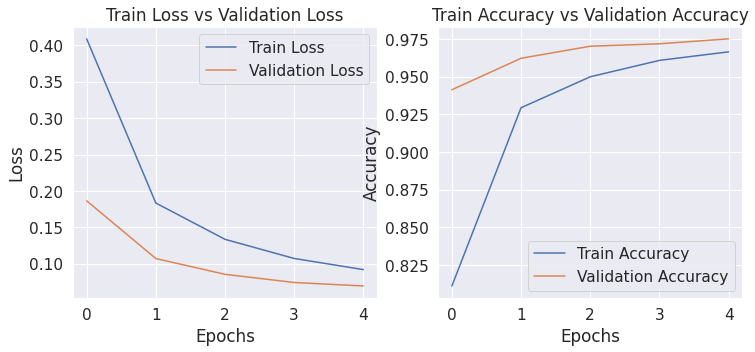

In [68]:
warnings.filterwarnings('ignore')
y_pred=lstm_model.predict(x_test_tf_dl)
ytrue = y_test.astype(int).tolist()
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)
history_lstm.history['precision']=precision
history_lstm.history['recall']=recall
history_lstm.history['f1score']=f1score
hist_df = pd.DataFrame(history_lstm.history) 
hist_df.to_csv("outputs//isot_dl_tfidf//model_ISOT_LSTM_TFIDF_V2_history.csv")
plot_loss_and_acc_from_hist2(hist_df)

#### Score metrics of the model

In [69]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.9790958975698981
precision = 0.9817708333333334
recall = 0.9722063037249283
f1score = 0.9769651598042038
[[4101   63]
 [  97 3393]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4164
           1       0.98      0.97      0.98      3490

    accuracy                           0.98      7654
   macro avg       0.98      0.98      0.98      7654
weighted avg       0.98      0.98      0.98      7654



**Save the classification report to csv**

In [70]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_dl_tfidf//model_ISOT_LSTM_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
,,,,
0,0.976894,0.984870,0.980866,4164.000000
1,0.981771,0.972206,0.976965,3490.000000
accuracy,0.979096,0.979096,0.979096,0.979096
macro avg,0.979332,0.978538,0.978915,7654.000000
weighted avg,0.979118,0.979096,0.979087,7654.000000


**Plot confusion matrix with normalised plot**

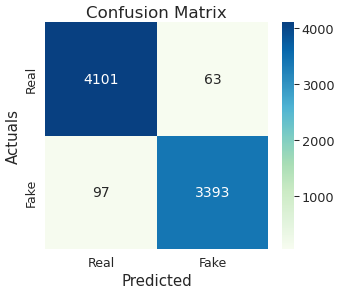

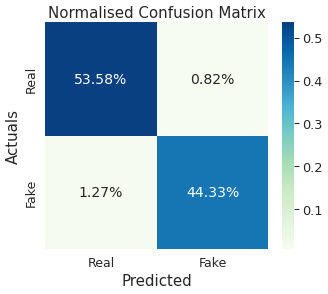

In [71]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//isot_dl_tfidf//isot_lstm_tfidf_cmtrx.png"
path2="outputs//isot_dl_tfidf//isot_lstm_tfidf_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Using BILSTM


#### Checkpoint and EarlyStopping configuration setting for the model training

In [72]:
# Model Checkpoint and EarlyStopping
filepath_bilstm = "outputs//isot_dl_tfidf//model_ISOT_BILSTM_TFIDF_V2.h5" # Location to get the model
checkpoint_bilstm = ModelCheckpoint(filepath_bilstm, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_bilstm = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_bilstm = [checkpoint_bilstm,es_bilstm]

#### Build the model 

In [73]:
bilstm_model = Sequential(name = 'bilstm_nn_model')

bilstm_model.add(Bidirectional(LSTM(512,input_shape=(1, max_features),return_sequences=True,
                                    dropout=0.2,recurrent_dropout=0.2)))

bilstm_model.add(BatchNormalization())
bilstm_model.add(Dense(512, activation='relu'))
bilstm_model.add(BatchNormalization())
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(64, activation='relu'))
bilstm_model.add(BatchNormalization())
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(1,activation='sigmoid'))
bilstm_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(2e-5),metrics=['accuracy'])
#bilstm_model.build(input_shape=(1, max_features)) 
#bilstm_model.summary()

In [74]:
clear_session()

#### Model Training

In [75]:
warnings.filterwarnings('ignore')
history_bilstm=bilstm_model.fit(x_train_tf_dl, y_train, epochs=5, batch_size=32,
                            validation_split=0.2, callbacks=callbacks_list_bilstm)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
765/766 [============================>.] - ETA: 0s - loss: 0.3385 - accuracy: 0.8494WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b2677692268> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

#### Evaluate the predictions made based on test data and calculate and plot the accuracy score metrics  

240/240 [==============================] - 2s 9ms/step
Training Accuracy : 0.9732157588005066
Validation Accuracy : 0.9755061864852905
Precision : 0.9836877366734634
Recall : 0.967621776504298
F1 Score : 0.9755886176513073


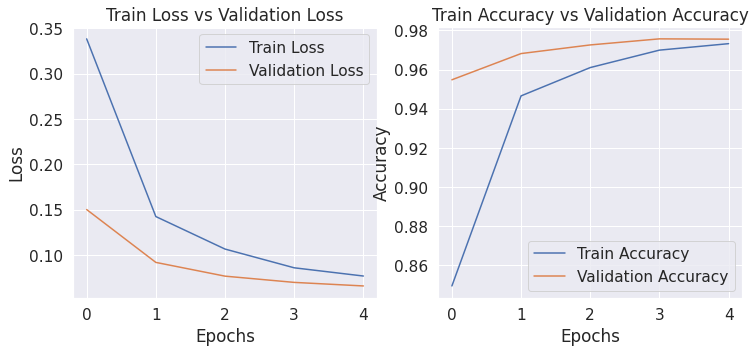

In [77]:
warnings.filterwarnings('ignore')
y_pred=bilstm_model.predict(x_test_tf_dl)
ytrue = y_test.astype(int).tolist()
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)
history_bilstm.history['precision']=precision
history_bilstm.history['recall']=recall
history_bilstm.history['f1score']=f1score
hist_df = pd.DataFrame(history_bilstm.history) 
hist_df.to_csv("outputs//isot_dl_tfidf//model_ISOT_BILSTM_TFIDF_V2_history.csv")
plot_loss_and_acc_from_hist2(hist_df)

#### Score metrics of the model

In [78]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.9779200418082049
precision = 0.9836877366734634
recall = 0.967621776504298
f1score = 0.9755886176513073
[[4108   56]
 [ 113 3377]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4164
           1       0.98      0.97      0.98      3490

    accuracy                           0.98      7654
   macro avg       0.98      0.98      0.98      7654
weighted avg       0.98      0.98      0.98      7654



**Save the classification report to csv**

In [79]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_dl_tfidf//model_ISOT_BILSTM_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
,,,,
0,0.973229,0.986551,0.979845,4164.00000
1,0.983688,0.967622,0.975589,3490.00000
accuracy,0.977920,0.977920,0.977920,0.97792
macro avg,0.978458,0.977087,0.977717,7654.00000
weighted avg,0.977998,0.977920,0.977904,7654.00000


**Plot confusion matrix with normalised plot**

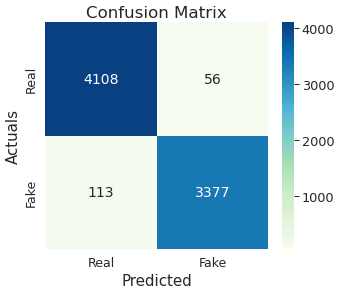

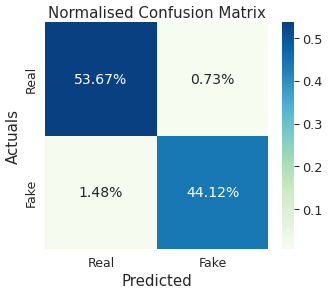

In [80]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//isot_dl_tfidf//isot_bilstm_tfidf_cmtrx.png"
path2="outputs//isot_dl_tfidf//isot_bilstm_tfidf_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)